In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('/content/airfoil_self_noise.dat',sep='\t',header=None)

In [ ]:
df.head()

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [ ]:
feature_names = ["Frequency", "Angle of Attack", "Chord Length", "Free-stream Velocity", "Suction Side Displacement Thickness"]

In [ ]:
df.shape

(1503, 6)

In [ ]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

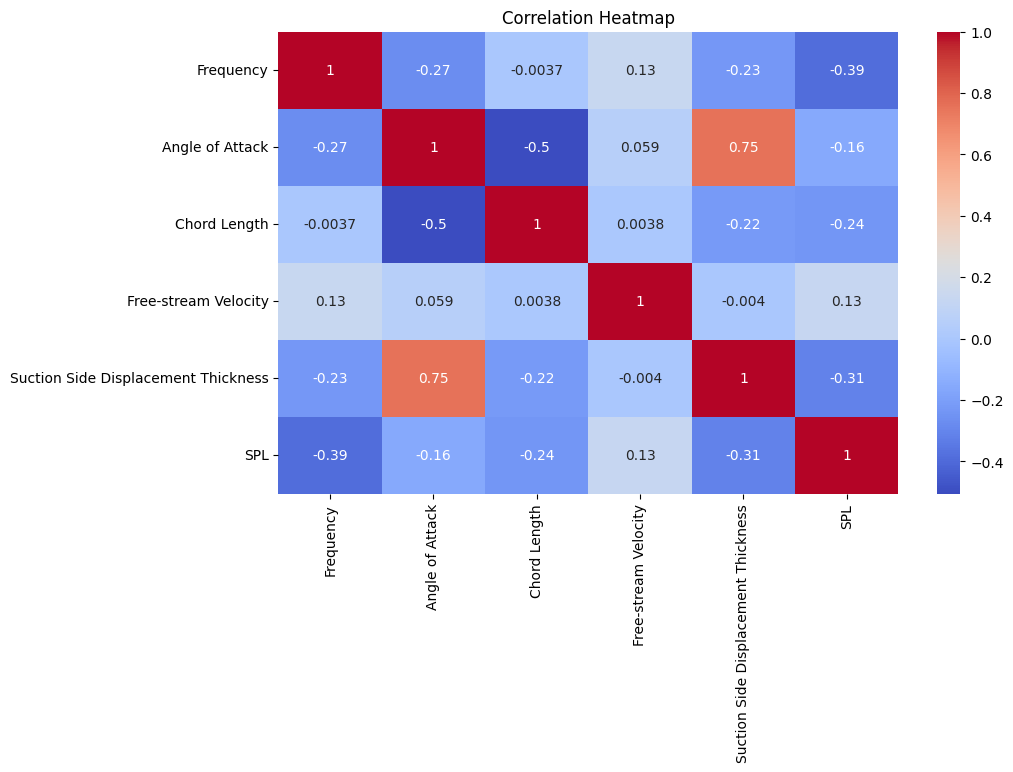

In [ ]:
import seaborn as sns
df.columns = feature_names + ["SPL"]
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

In [ ]:
scaling = StandardScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)
Y_train = scaling.fit_transform(y_train.reshape(-1,1))
Y_test = scaling.transform(y_test.reshape(-1,1))

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
training= DataLoader(train_ds, batch_size=32, shuffle=True)
testing = DataLoader(test_ds, batch_size=32)

In [ ]:
import torch
from torch import nn

In [ ]:
class Model1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer=nn.Sequential(
        nn.Linear(5,8),
        nn.ReLU(),
        nn.Linear(8,32),
        nn.ReLU(),
        nn.Linear(32,1)
    )
  def forward(self,x):
    return self.layer(x)

In [ ]:
model=Model1()

In [ ]:
model

Model1(
  (layer): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
loss_fn=nn.MSELoss()
optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [ ]:
torch.manual_seed(69)
epochs = 45

for epoch in range(epochs+1):
    model.train()
    train_loss = 0
    for batch_X, batch_y in training:
        y_preds = model(batch_X)
        loss = loss_fn(y_preds, batch_y)

        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss += loss.item()
    train_loss /= len(training)

    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for batch_X, batch_y in testing:
            test_preds = model(batch_X)
            loss = loss_fn(test_preds, batch_y)
            test_loss += loss.item()
    test_loss /= len(testing)

    if epoch % 2 == 0:
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


Epoch 00 | Train Loss: 1.0187 | Test Loss: 1.0462
Epoch 02 | Train Loss: 0.8307 | Test Loss: 0.7935
Epoch 04 | Train Loss: 0.5771 | Test Loss: 0.4954
Epoch 06 | Train Loss: 0.4345 | Test Loss: 0.3641
Epoch 08 | Train Loss: 0.3818 | Test Loss: 0.3328
Epoch 10 | Train Loss: 0.3572 | Test Loss: 0.3167
Epoch 12 | Train Loss: 0.3433 | Test Loss: 0.3044
Epoch 14 | Train Loss: 0.3178 | Test Loss: 0.2970
Epoch 16 | Train Loss: 0.3047 | Test Loss: 0.2891
Epoch 18 | Train Loss: 0.3018 | Test Loss: 0.2827
Epoch 20 | Train Loss: 0.2879 | Test Loss: 0.2793
Epoch 22 | Train Loss: 0.2840 | Test Loss: 0.2669
Epoch 24 | Train Loss: 0.2679 | Test Loss: 0.2663
Epoch 26 | Train Loss: 0.2650 | Test Loss: 0.2600
Epoch 28 | Train Loss: 0.2653 | Test Loss: 0.2548
Epoch 30 | Train Loss: 0.2559 | Test Loss: 0.2464
Epoch 32 | Train Loss: 0.2384 | Test Loss: 0.2397
Epoch 34 | Train Loss: 0.2378 | Test Loss: 0.2341
Epoch 36 | Train Loss: 0.2330 | Test Loss: 0.2287
Epoch 38 | Train Loss: 0.2196 | Test Loss: 0.2256


In [ ]:
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    r2 = r2_score(y_test.numpy(), y_pred.numpy())
    print(f"R² score on test set: {r2:.4f}")

R² score on test set: 0.7956


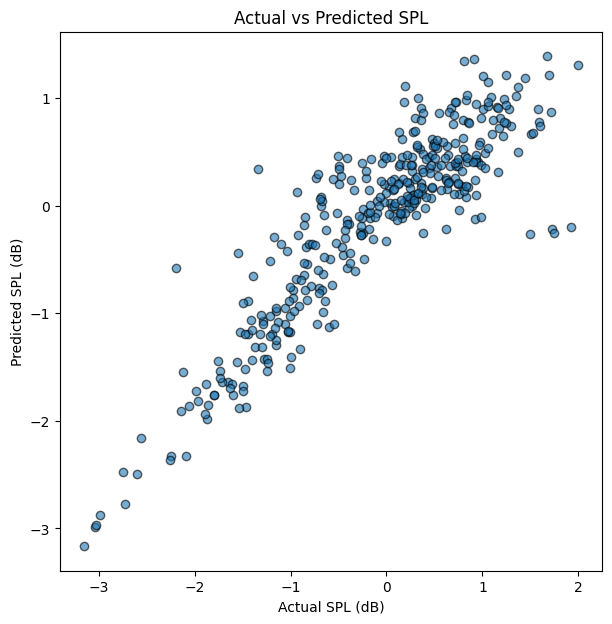

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="k")
#plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], lw=2)
plt.xlabel("Actual SPL (dB)")
plt.ylabel("Predicted SPL (dB)")
plt.title("Actual vs Predicted SPL")
plt.show()